In [1]:
!pip install --upgrade setuptools pip --user
!pip install onnx 
!pip install onnxruntime
#!pip install --ignore-installed PyYAML
#!pip install Pillow

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/bin/bash: line 1: 4.21.3: No such file or directory
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:18) 
[GCC 10.3.0], sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0) 
Pytorch version: 1.12.1 


/home/xin/anaconda3/envs/yolov7/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!nvidia-smi

Wed Aug 31 10:16:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   41C    P8    15W / 350W |     19MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 30%   

In [3]:
# !# Download YOLOv7 code
# !git clone https://github.com/WongKinYiu/yolov7
# %cd yolov7
# !ls

In [5]:
# !# Download trained weights
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [11]:
!python detect.py --weights runs/train/yolov7-tiny-custom2/weights/best.pt --conf 0.5 --img-size 640 --source /home/xin/OneDrive/xin/cv/data/bones1.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/home/xin/OneDrive/xin/cv/data/bones1.jpg', update=False, view_img=False, weights=['runs/train/yolov7-tiny-custom2/weights/best.pt'])
YOLOR 🚀 44d8ab4 torch 1.12.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24265.8125MB)
                             CUDA:1 (NVIDIA GeForce RTX 3090, 24268.3125MB)

Fusing layers... 
/home/xin/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 200 layers, 6006646 parameters, 0 gradients, 13.0 GFLOPS
 Conver

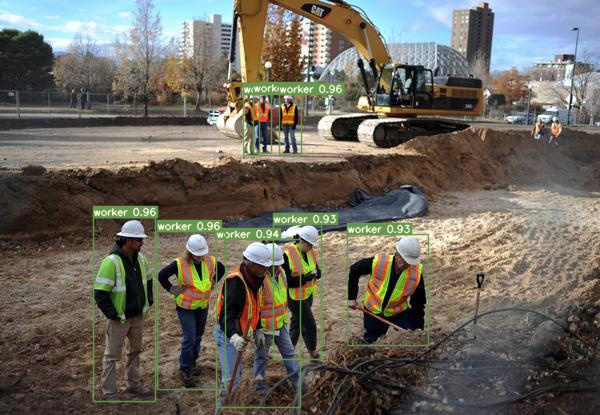

In [12]:
from PIL import Image
Image.open('./runs/detect/exp/bones1.jpg')

In [4]:
# export ONNX for ONNX inference
!python export.py --weights ./runs/train/yolov7-tiny-custom2/weights/best.pt \
        --grid --end2end --simplify\
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS, 
                     # otherwise it is non-agnostic NMS

Namespace(batch_size=1, conf_thres=0.35, device='cpu', dynamic=False, dynamic_batch=False, end2end=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.65, max_wh=640, simplify=True, topk_all=100, weights='./runs/train/yolov7-tiny-custom2/weights/best.pt')
YOLOR 🚀 44d8ab4 torch 1.12.1 CPU

Fusing layers... 
/home/xin/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 200 layers, 6006646 parameters, 0 gradients, 13.0 GFLOPS

Starting TorchScript export with torch 1.12.1...
/home/xin/OneDrive/xin/yolov7/models/yolo.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't

In [7]:
# Inference for ONNX model
import cv2
cuda = True
w = "./runs/train/yolov7-tiny-custom2/weights/best.onnx"
img = cv2.imread('/home/xin/OneDrive/xin/cv/data/bones1.jpg')

In [8]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['worker']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

In [9]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs

array([[  0.        ,  99.0552    , 329.8445    , 165.63223   ,
        525.21985   ,   0.        ,   0.9563887 ],
       [  0.        , 166.9891    , 344.7559    , 240.00052   ,
        513.1321    ,   0.        ,   0.9504006 ],
       [  0.        , 297.96677   , 198.55713   , 321.42783   ,
        263.0395    ,   0.        ,   0.9494018 ],
       [  0.        , 229.83025   , 357.37152   , 317.13147   ,
        529.1963    ,   0.        ,   0.92156357],
       [  0.        , 290.97577   , 337.1187    , 342.27722   ,
        481.73645   ,   0.        ,   0.92115676],
       [  0.        , 370.19662   , 348.41818   , 456.41476   ,
        466.87515   ,   0.        ,   0.9209283 ],
       [  0.        , 270.00034   , 198.73976   , 289.57516   ,
        261.39594   ,   0.        ,   0.8268985 ],
       [  0.        , 259.59335   , 200.74336   , 276.0305    ,
        264.24475   ,   0.        ,   0.69213516]], dtype=float32)

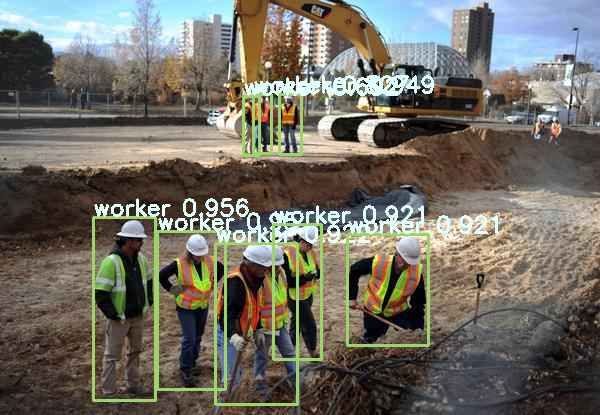

In [10]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0])